## Gerando dados sintéticos a partir da adição de ruído Gaussiano

In [322]:
from braindecode.datasets import MOABBDataset

dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[8])

48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]


In [323]:
from braindecode.preprocessing import preprocess, Preprocessor
import numpy as np
from numpy import multiply

low_cut_hz = 4.
high_cut_hz = 38.
newfreq = 128
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),
    Preprocessor(lambda data: multiply(data, factor)),
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    Preprocessor("set_eeg_reference", ref_channels="average", ch_type="eeg")
]

preprocess(dataset, preprocessors, n_jobs=-1);

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

/home/matias/Mestrado/venv_BCI/venv_BCI/lib/python3.7/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
-

In [324]:
from braindecode.preprocessing import create_windows_from_events

sfreq = dataset.datasets[0].raw.info['sfreq']

trial_start_offset_seconds = -0.5
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [325]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

X_ = []
y_ = []

X_0 = []
X_1 = []
X_2 = []
X_3 = []

for X, y, (i_window_in_trial, i_start_sample, i_stop_sample) in windows_dataset:
    X_.append(X)
    y_.append(y)

X_ = torch.as_tensor(X_).float()
y_ = torch.as_tensor(y_)

noise = np.random.normal(0,1,(576, 22, 1125))
fake_X_ = X_ + noise

fake_X_ = torch.as_tensor(fake_X_).float()

real_set = TensorDataset(X_, y_)
fake_set = TensorDataset(fake_X_, y_)

print(X_.shape)
print(y_.shape)

torch.Size([576, 22, 1125])
torch.Size([576])


In [326]:
import numpy as np
from scipy import signal

window_size = 128
overlap = 64
fft_size = 128
sampling_rate = 250

spectrograms_spectrogram = []

for i in range(X_.shape[0]):
    f, t, spectrogram = signal.spectrogram(X_[i, :], fs=sampling_rate, window='hann', nperseg=window_size, noverlap=overlap, nfft=fft_size)
    spectrograms_spectrogram.append(spectrogram)

spectrograms_spectrogram = np.array(spectrograms_spectrogram)

(576, 22, 65, 16)


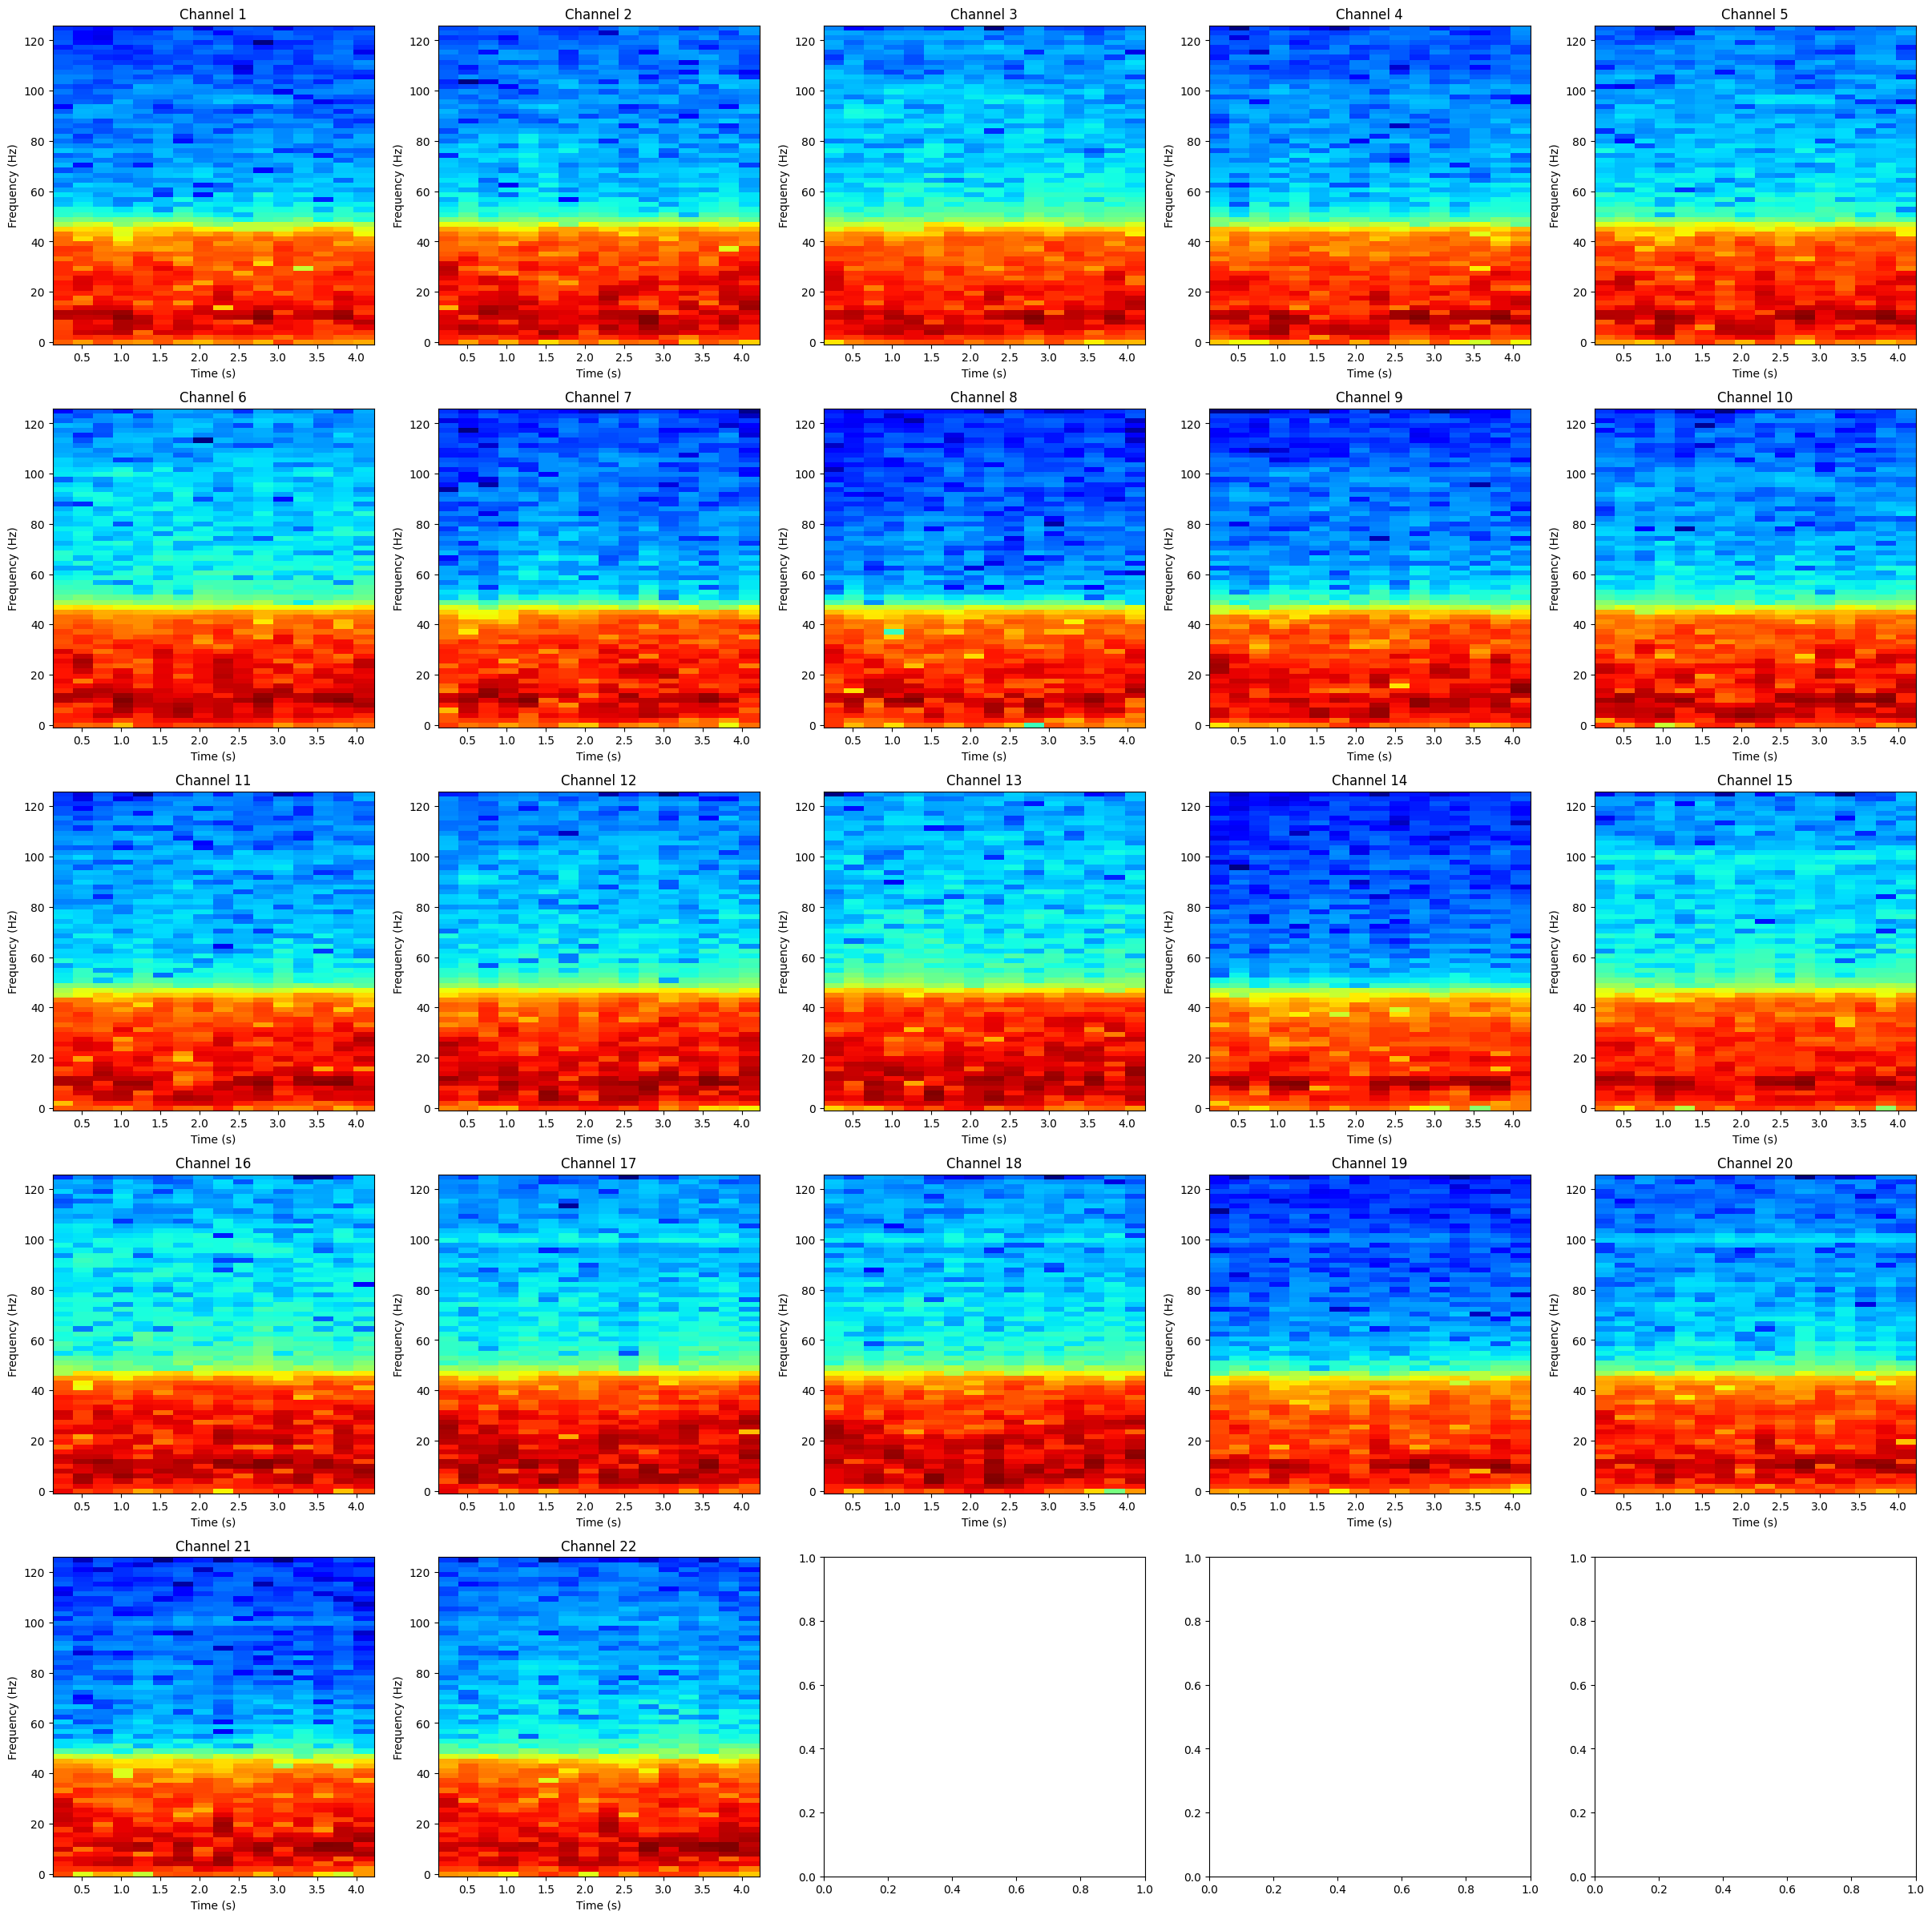

In [327]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(30, 30))
for i in range(5):
    for j in range(5):
        axs[i,j].pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][i*5+j, :, :])), cmap='jet')
        axs[i,j].set_title('Channel ' + str(i*5+j+1))
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        if(i*5+j == 21):
            break
    if(i*5+j == 21):
        break

print(spectrograms_spectrogram.shape)
plt.show()

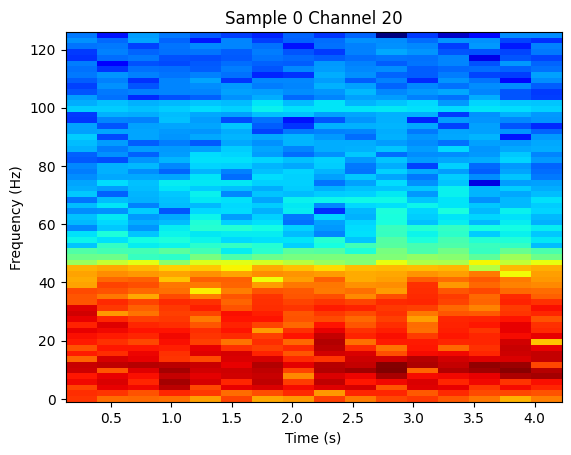

In [328]:
plt.pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][19, :, :])), cmap='jet')
plt.title('Sample 0 Channel 20')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [329]:
spectrograms_spectrogram = []

for i in range(fake_X_.shape[0]):
    f, t, spectrogram = signal.spectrogram(fake_X_[i, :], fs=sampling_rate, window='hann', nperseg=window_size, noverlap=overlap, nfft=fft_size)
    spectrograms_spectrogram.append(spectrogram)

spectrograms_spectrogram = np.array(spectrograms_spectrogram)

(576, 22, 65, 16)


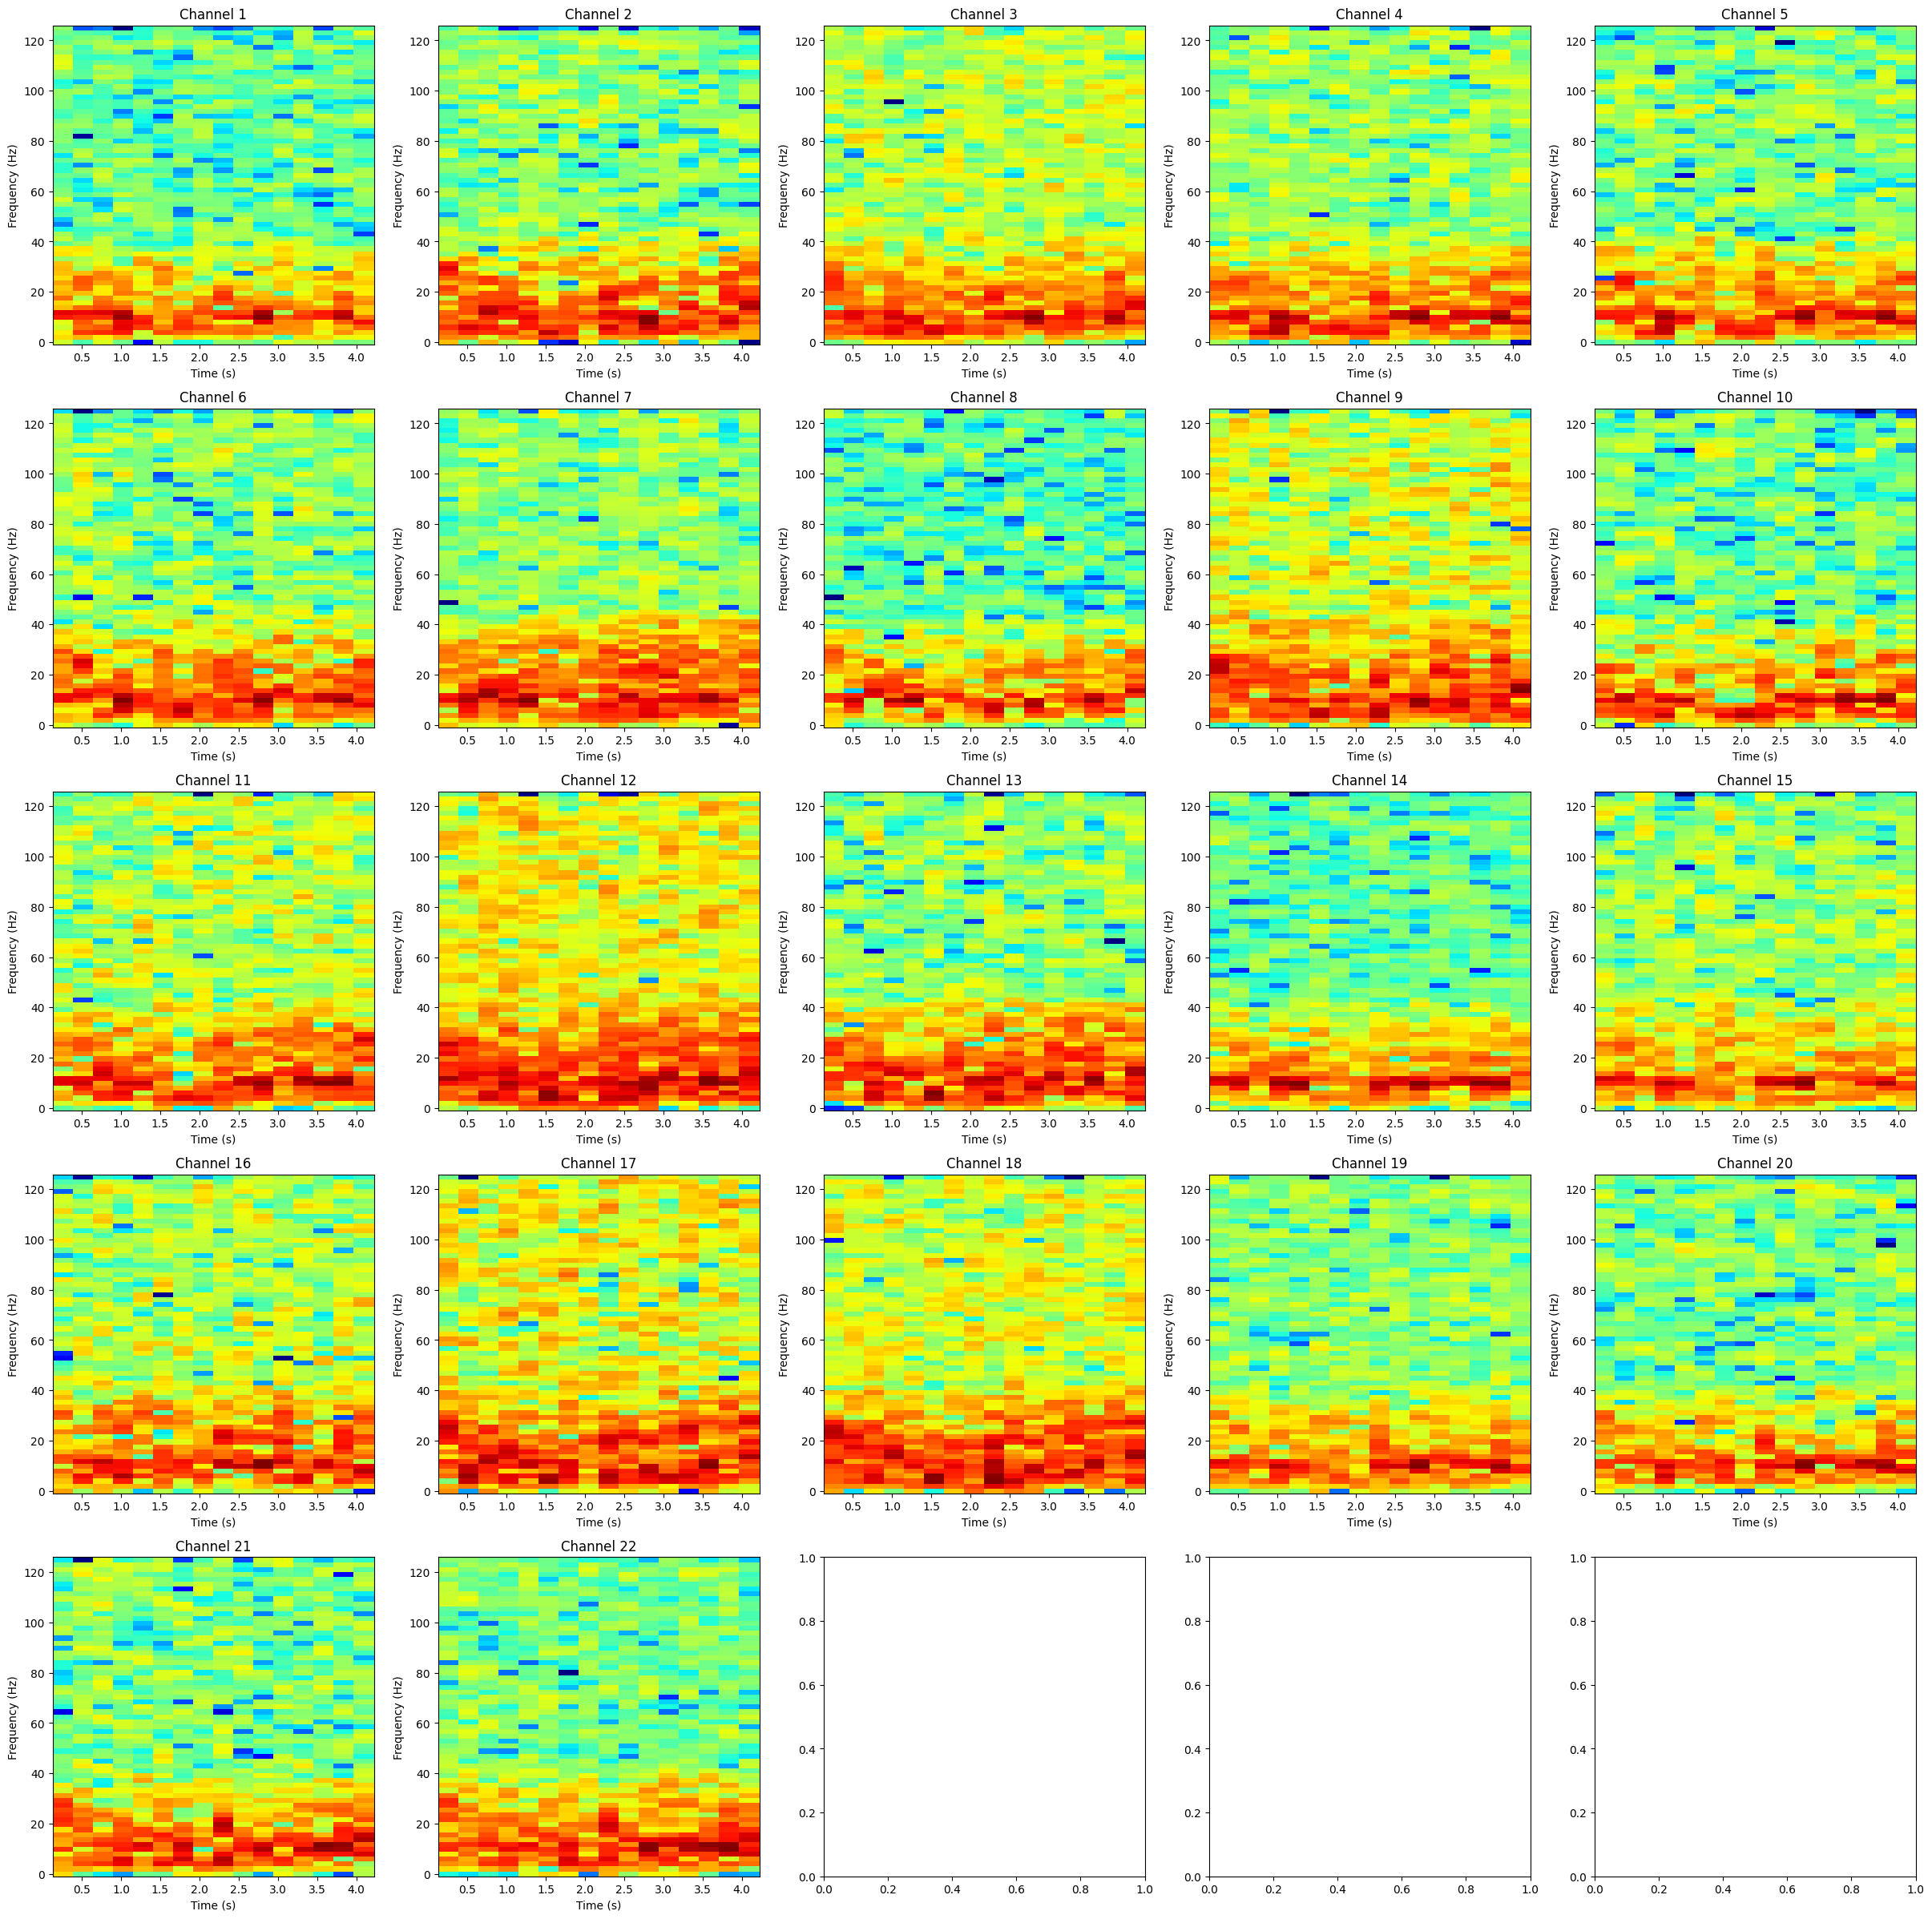

In [330]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(30, 30))
for i in range(5):
    for j in range(5):
        axs[i,j].pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][i*5+j, :, :])), cmap='jet')
        axs[i,j].set_title('Channel ' + str(i*5+j+1))
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        if(i*5+j == 21):
            break
    if(i*5+j == 21):
        break

print(spectrograms_spectrogram.shape)
plt.show()

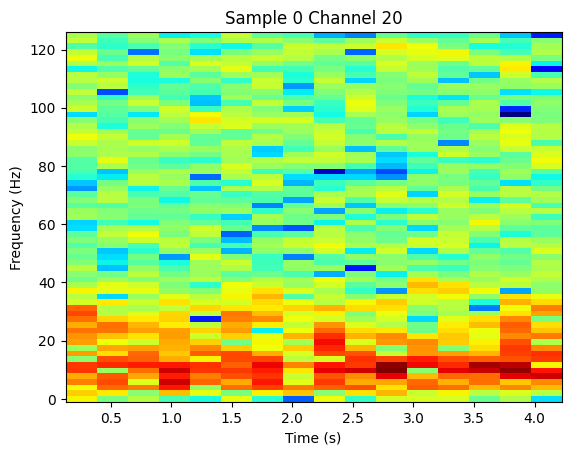

In [331]:
plt.pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][19, :, :])), cmap='jet')
plt.title('Sample 0 Channel 20')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Processamento dos dados sintéticos para classificação

In [332]:
from torch.utils.data import random_split

fake_fulltrainset, fake_evalset = random_split(fake_set, [288, 288])
fake_trainset, fake_testset = random_split(fake_fulltrainset, [192, 96])
real_fulltrainset, real_evalset = random_split(real_set, [288, 288])
real_trainset, real_testset = random_split(real_fulltrainset, [192, 96])

## Definição do modelo do classificador

In [333]:
from braindecode.util import set_random_seeds
from braindecode.models import EEGNetv4

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = False

seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
n_chans = 22
input_window_samples = 1125
F1, D = 4, 2
kernel_length = 64

model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    F1=8,
    D=2,
    F2=F1*D,
    kernel_length=kernel_length,
    drop_prob=0.5
)
model.to(device);

## Treinamento do classificador com dados reais

In [334]:
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
from braindecode import EEGClassifier

batch_size = 32
n_epochs = 50

real_clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(real_testset),
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
real_clf.fit(real_trainset, y=None, epochs=n_epochs);

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.3385        1.3804            0.2812        1.3612  0.0100  0.0819
      2            0.4896        1.3538            0.4375        1.2735  0.0100  0.0820
      3            0.3646        1.2766            0.3438        1.2586  0.0100  0.0815
      4            0.2760        1.1300            0.3438        1.4929  0.0099  0.0811
      5            0.2604        1.0864            0.3438        1.7950  0.0098  0.0752
      6            0.2604        1.0344            0.2917        2.2774  0.0097  0.0748
      7            0.3281        0.9264            0.3125        2.2595  0.0096  0.0741
      8            0.4167        0.8960            0.3229        2.1992  0.0095  0.0730
      9            0.4896        0.8196            0.3958        2.0675  0.0094  0.0735
     10            0.5469       

In [335]:
print(f"Mean Accuracy: {np.mean(real_clf.predict(real_evalset) == [y for X,y in real_evalset])*100:.2f}%")

Mean Accuracy: 75.35%


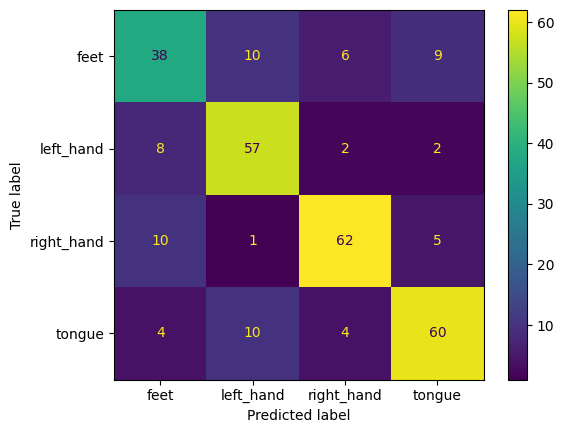

In [336]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

trtr = real_clf.predict(real_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in real_evalset],
    y_pred=trtr,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [337]:
print(f"Mean Accuracy: {np.mean(real_clf.predict(fake_evalset) == [y for X,y in fake_evalset])*100:.2f}%")

Mean Accuracy: 84.72%


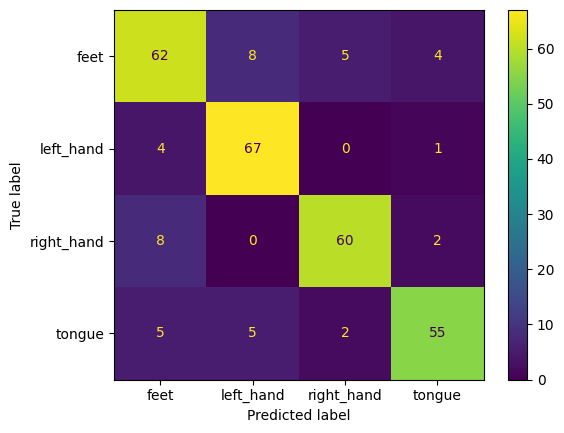

In [338]:
trts = real_clf.predict(fake_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in fake_evalset],
    y_pred=trts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

## Treinamento do classificador com dados sintéticos

In [339]:
fake_clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(fake_testset),
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
fake_clf.fit(fake_trainset, y=None, epochs=n_epochs);

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.8021        0.8846            0.8021        0.6279  0.0100  0.0738
      2            0.7656        0.6745            0.6875        0.9255  0.0100  0.0733
      3            0.8177        0.7095            0.7396        0.9071  0.0100  0.0735
      4            0.8385        0.5232            0.7500        0.8946  0.0099  0.0743
      5            0.7760        0.4940            0.6771        1.0136  0.0098  0.0736
      6            0.7656        0.4433            0.6562        1.3072  0.0097  0.0736
      7            0.7760        0.4737            0.6562        1.3401  0.0096  0.0745
      8            0.8177        0.3495            0.7083        1.1154  0.0095  0.0751
      9            0.8594        0.3797            0.7292        0.9946  0.0094  0.0733
     10            0.8698       

In [340]:
print(f"Mean Accuracy: {np.mean(fake_clf.predict(real_evalset) == [y for X,y in real_evalset])*100:.2f}%")

Mean Accuracy: 87.85%


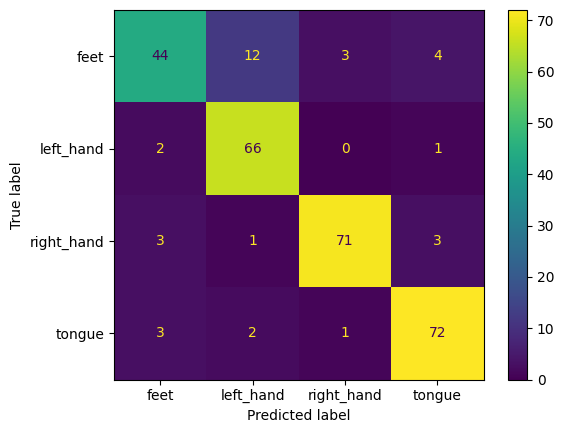

In [341]:
tstr = real_clf.predict(real_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in real_evalset],
    y_pred=tstr,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [342]:
print(f"Mean Accuracy: {np.mean(fake_clf.predict(fake_evalset) == [y for X,y in fake_evalset])*100:.2f}%")

Mean Accuracy: 77.43%


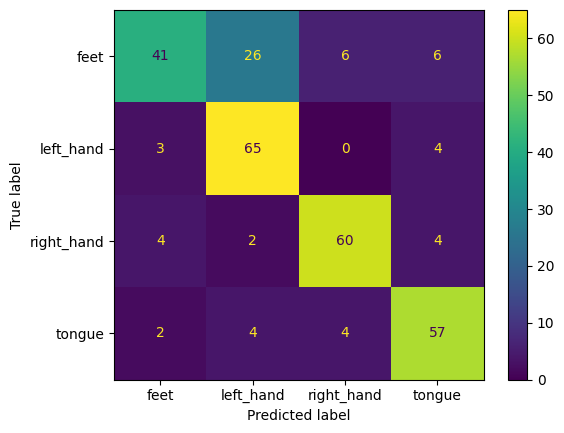

In [343]:
tsts = real_clf.predict(fake_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in fake_evalset],
    y_pred=tsts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

## Distância euclidiana entre os dados reais e sintéticos

In [344]:
size=(22, 1125)
real = X_.view(-1, *size)
fake = fake_X_.view(-1, *size)

In [345]:
torch.norm(real-fake, 2)

tensor(3774.0364)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do